In [1]:
# default_exp models.weaksupervision

# models.weaksupervision

> API details.

In [2]:
# export
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import torch
from torch import nn
from fastrenewables.tabular.core import *
from fastrenewables.tabular.model import *
from fastrenewables.tabular.learner import *
from fastrenewables.timeseries.model import *
from fastai.tabular.all import *
from torch.autograd import Variable
from fastai.learner import *
from fastrenewables.utils_pytorch import *
from fastrenewables.utils import filter_preds

import copy

from fastrenewables.baselines import BayesLinReg, MCLeanPowerCurve
from fastrenewables.tabular.learner import convert_to_tensor
from fastrenewables.losses import *



from fastrenewables.timeseries.core import *
from fastrenewables.timeseries.model import *
from fastrenewables.timeseries.learner import *

In [3]:
def read_hdf(name):
    with pd.HDFStore(name) as store:
        df = store["powerdata"]
        df["TaskID"] = 0
    return df

In [4]:
def filter_weak_labels(preds):
    _,preds = filter_preds(None, preds, filter_nas=False)
    return preds

In [5]:
def get_preds(to, model):
    conts_as_tensor = torch.tensor(to.conts.values).float()
    model.eval()
    with torch.no_grad():
        preds = filter_weak_labels(model(None, conts_as_tensor))
    return filter_weak_labels(to_np(preds))

In [6]:
def match_time_stamps(df_1, df_2):
    mask_df1 = df_1.index.isin(df_2.index)
    df_1 = df_1[mask_df1]

    mask_df2 = df_2.index.isin(df_1.index)
    df_2 = df_2[mask_df2]

    return df_1, df_2

In the following we develop the crow layer according to https://ojs.aaai.org/index.php/AAAI/article/view/11506. We will use this layer in a weak supervision approach along with transfer learning.
The goal is to pre-train a source model, afterwards this model is adapted with weak labels from the McLean power curve on a target park. 
Ideally, the transfered model should be better than the physical model.

In [7]:
cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
       'ASWDIRS_SFC_0_M', 'TestFlag', 'PowerGeneration', 'WindSpeed58m',
       'SinWindDirection58m', 'CosWindDirection58m', 'WindSpeed60m',
       'SinWindDirection60m', 'CosWindDirection60m', ]
y_names= ["PowerGeneration"]

In [8]:
def train_learner(park_name):
    df = read_hdf(park_name)
    mask_train = df.index.year<2020
    df = df[mask_train]

    to_source = TabularRenewables(df,   
                      pre_process=[CreateTimeStampIndex(index_col_name="TimeUTC"),
    #                                AddSeasonalFeatures(as_cont=True),
                                   FilterInconsistentSamplesPerDay,
                                  ], 
                      procs=[NormalizePerTask(norm_type="minmaxnorm")], 
                      y_block=RegressionBlock(),
                      splits = TrainTestSplitByDays(),
                      cont_names=cont_names, y_names=y_names)
    dls = to_source.dataloaders()

    model = MultiLayerPerceptron([len(cont_names), 100, 50, 10, len(y_names)])
    learner = RenewableLearner(dls, model, metrics=rmse)
    learner.fit(5)
    
    return learner, to_source

In [9]:
learner, to_source = train_learner("../data/00011.h5")

epoch,train_loss,valid_loss,_rmse,time
0,0.010431,0.003276,0.057234,00:00
1,0.004811,0.002022,0.044971,00:00
2,0.003250,0.000998,0.031599,00:00
3,0.002655,0.001237,0.035175,00:00
4,0.002263,0.000974,0.031207,00:00


In [10]:
learner2, to_source2 = train_learner("../data/00161.h5")

epoch,train_loss,valid_loss,_rmse,time
0,0.013720,0.004129,0.064260,00:00
1,0.005580,0.001985,0.044553,00:01
2,0.003317,0.001221,0.034939,00:00
3,0.002944,0.001181,0.034366,00:00
4,0.002313,0.000737,0.027139,00:00


In [11]:
with pd.HDFStore("../data/00090.h5") as store:
    df = store["powerdata"]
    df["TaskID"] = 0
    
to_target_tmp = to_source2.new(df)
to_target_tmp.process()
df['Y_weak_01'] = get_preds(to_target_tmp, learner2.model)
to_target_tmp = to_source.new(df)
to_target_tmp.process()
df['Y_weak_02'] = get_preds(to_target_tmp, learner.model)

In [12]:
y_names_target = [c for c in df.columns if "Y_weak" in c]

In [13]:
y_names_target

['Y_weak_01', 'Y_weak_02']

In [14]:
mask_train = df.index.year<2020
df_train = df[mask_train]
df_test = df[~mask_train]

In [15]:
to_target = TabularRenewables(df_train,   
                  pre_process=[CreateTimeStampIndex(index_col_name="TimeUTC"),
                               FilterInconsistentSamplesPerDay,
                              ], 
                  procs=[NormalizePerTask(norm_type="minmaxnorm")], 
                  y_block=RegressionBlock(),
                  splits = TrainTestSplitByDays(),
                  cont_names=cont_names, y_names=y_names_target)

In [16]:
to_target_test = to_target.new(df_test)
to_target_test.process()

In [17]:
to_target.ys.head(1)

,Y_weak_01,Y_weak_02
TimeUTC,,
2019-01-01 00:00:00+00:00,0.069812,0.0


If we were to select a source model, we can do this via some meta data of from the input space.
In the latter case the second park seems to be more similar to the target than the first one.

In [18]:
df_1,df_2 = to_source.items, to_target.items
df_1,df_2 = match_time_stamps(df_1,df_2)
((df_1.WindSpeed58m-df_2.WindSpeed58m)**2).mean()**0.5

0.16115414890671131

In [19]:
df_1,df_2 = to_source2.items, to_target.items
df_1,df_2 = match_time_stamps(df_1,df_2)
((df_1.WindSpeed58m-df_2.WindSpeed58m)**2).mean()**0.5

0.13132529181355349

Let us calculate the actual zero shot errors on the target from the two source models.

In [20]:
preds = get_preds(to_target_test, learner.model)
((to_target_test.items.PowerGeneration.values.ravel()-preds.ravel())**2).mean()**0.5

0.04898922785872488

In [21]:
preds = get_preds(to_target_test, learner2.model)
((to_target_test.items.PowerGeneration.values.ravel()-preds.ravel())**2).mean()**0.5

0.07665698772803184

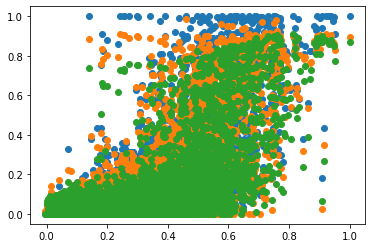

In [22]:
plt.scatter(to_target.items.WindSpeed60m, to_target.items.PowerGeneration)
plt.scatter(to_target.items.WindSpeed60m, to_target.items.Y_weak_01)
plt.scatter(to_target.items.WindSpeed60m, to_target.items.Y_weak_02)

In [23]:
# export
class CrowdLayer(nn.Module):
    def __init__(
        self,
        source_model,
        num_weak_labels=1,
        num_timesteps=1,
        layer_type="bias"
    ):
        super().__init__()
        
        self.num_weak_labels=num_weak_labels
        self.num_timesteps=num_timesteps
        
        # the "1" broadcast through the samples
        # we expect for both cases a univariate output
        if self.num_timesteps == 1:
            self.bias = nn.Parameter(torch.zeros(1, num_weak_labels))
        else:
            self.bias = nn.Parameter(torch.zeros(1, num_weak_labels, self.num_timesteps))
        self.bias.requires_grad=True
        self.source_model=source_model
        if layer_type != "bias":
            raise NotImplementedError
        self.layer_type = layer_type
    def forward(self, cats, conts):
        x = conts
        if self.source_model is not None:
            x = self.source_model(cats, conts)
        
        if x.shape[1] != 1:
            raise ValueError("Only univariate outputs are supported.")
   
        return x + self.bias

In [24]:
dls_target = to_target.dataloaders(shuffle=True, drop_last=True)

In [25]:
target_model = CrowdLayer(copy.deepcopy(learner2.model), num_weak_labels=len(to_target.y_names), num_timesteps=1)

In [26]:
target_learner = RenewableLearner(dls_target, target_model, metrics=rmse)
target_learner.fit(5, lr=1e-4)

epoch,train_loss,valid_loss,_rmse,time
0,0.003450,0.001794,0.042354,00:00
1,0.003301,0.001579,0.039738,00:00
2,0.002529,0.001563,0.039531,00:00
3,0.002665,0.001459,0.038196,00:00
4,0.002821,0.001545,0.039312,00:00


In [27]:
preds = get_preds(to_target_test, target_learner.model.source_model)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


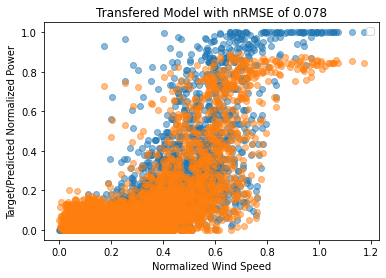

In [28]:
e = ((to_target_test.items.PowerGeneration.values.ravel()-preds.ravel())**2).mean()**0.5
plt.scatter(to_target_test.items.WindSpeed60m, to_target_test.items.PowerGeneration,alpha=0.5 )
plt.scatter(to_target_test.items.WindSpeed60m, preds,alpha=0.5)
plt.xlabel("Normalized Wind Speed")
plt.ylabel("Target/Predicted Normalized Power")
plt.title(f"Transfered Model with nRMSE of {e:.03f}")
plt.legend()
plt.show()

In [29]:
target_learner.model.bias

Parameter containing:
tensor([[ 0.0161, -0.0037]], requires_grad=True)

In [30]:
model = MultiLayerPerceptron([len(cont_names), 100, 50, 10, len(y_names)])
target_model = CrowdLayer(model, num_weak_labels=len(to_target.y_names), num_timesteps=1)

In [31]:
target_learner = RenewableLearner(dls_target, target_model, metrics=rmse)
target_learner.fit(10, lr=1e-4)

epoch,train_loss,valid_loss,_rmse,time
0,0.098574,0.044261,0.210384,00:00
1,0.040430,0.022685,0.150614,00:00
2,0.022610,0.013801,0.117478,00:00
3,0.014419,0.009416,0.097034,00:00
4,0.010555,0.006874,0.082909,00:00
5,0.008345,0.005604,0.074863,00:00
6,0.007545,0.004323,0.065746,00:00
7,0.006176,0.003624,0.060196,00:00
8,0.005393,0.003339,0.057785,00:00
9,0.005074,0.003381,0.058146,00:00


In [32]:
target_learner.model.bias

Parameter containing:
tensor([[0.0534, 0.0341]], requires_grad=True)

In [33]:
preds = get_preds(to_target_test, target_learner.model.source_model)

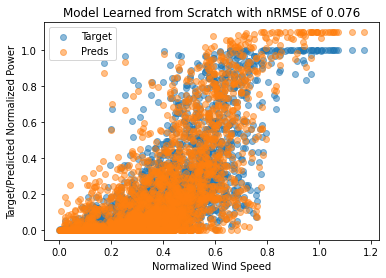

In [34]:
e = ((to_target_test.items.PowerGeneration.values.ravel()-preds.ravel())**2).mean()**0.5
plt.scatter(to_target_test.items.WindSpeed60m, to_target_test.items.PowerGeneration, label="Target",alpha=0.5)
plt.scatter(to_target_test.items.WindSpeed60m, preds, label="Preds",alpha=0.5)
plt.xlabel("Normalized Wind Speed")
plt.ylabel("Target/Predicted Normalized Power")
plt.title(f"Model Learned from Scratch with nRMSE of {e:.03f}")
plt.legend()
plt.show()

In [35]:
to_target_ts = Timeseries(to_target, splits=RandomSplitter(0.1))
dl_target_ts = to_target_ts.dataloaders(shuffle=True, drop_last=True)

/home/scribbler/anaconda/lib/python3.8/site-packages/fastrenewables/timeseries/core.py:329: UserWarning: Splitting in TabularRenewables is not supported.                           Otherwise a correct splitting for timeseries is not assured.                           Fallback to complete data.
  warnings.warn("Splitting in TabularRenewables is not supported. \


In [36]:
target_model = TemporalCNN([len(cont_names), 100, 50, 20, 10, 5, 1], cnn_type="TCN")
target_model = CrowdLayer(target_model, num_weak_labels=2, num_timesteps=24)
target_model

CrowdLayer(
  (source_model): TemporalCNN(
    (bn_cont): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): TemporalConvNet(
      (temporal_blocks): Sequential(
        (0): ResidualBlock(
          (conv1): Conv1d(13, 100, kernel_size=(3,), stride=(1,), padding=(2,))
          (chomp1): Chomp1d()
          (act_func1): ReLU()
          (dropout1): Dropout2d(p=0.0, inplace=False)
          (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(2,))
          (chomp2): Chomp1d()
          (act_func2): ReLU()
          (dropout2): Dropout2d(p=0.0, inplace=False)
          (net): Sequential(
            (0): Conv1d(13, 100, kernel_size=(3,), stride=(1,), padding=(2,))
            (1): Chomp1d()
            (2): ReLU()
            (3): Dropout2d(p=0.0, inplace=False)
            (4): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(2,))
            (5): Chomp1d()
            (6): ReLU()
            (7): Dropout2d(p=0.0, inplac

In [37]:
learner_target_ts = RenewableTimeseriesLearner(dl_target_ts, target_model, metrics=rmse)

In [38]:
learner_target_ts.fit(20, lr=1e-4)

epoch,train_loss,valid_loss,_rmse,time
0,0.063369,0.049678,0.222886,00:00
1,0.057888,0.047289,0.217460,00:00
2,0.054012,0.044485,0.210915,00:00
3,0.050666,0.042047,0.205053,00:00
4,0.047840,0.040115,0.200287,00:00
5,0.045455,0.037994,0.194920,00:00
6,0.042778,0.035875,0.189407,00:00
7,0.040693,0.033783,0.183800,00:00
8,0.038616,0.031546,0.177612,00:00
9,0.036643,0.029364,0.171361,00:00


In [39]:
learner_target_ts.model.bias

Parameter containing:
tensor([[[0.0083, 0.0084, 0.0083, 0.0082, 0.0078, 0.0080, 0.0081, 0.0082,
          0.0083, 0.0086, 0.0085, 0.0081, 0.0085, 0.0083, 0.0083, 0.0080,
          0.0069, 0.0063, 0.0061, 0.0063, 0.0070, 0.0066, 0.0065, 0.0069],
         [0.0066, 0.0074, 0.0073, 0.0074, 0.0068, 0.0071, 0.0074, 0.0073,
          0.0073, 0.0074, 0.0076, 0.0074, 0.0077, 0.0075, 0.0075, 0.0068,
          0.0051, 0.0035, 0.0040, 0.0037, 0.0051, 0.0048, 0.0042, 0.0052]]],
       requires_grad=True)

In [40]:
to_target_test_ts = Timeseries(to_target_test)

In [41]:
with torch.no_grad():
    learner_target_ts.model.eval()
    preds = learner_target_ts.model.source_model(None,to_target_test_ts.conts)
    preds = to_np(preds).reshape(-1)
    _,preds = filter_preds(None,preds,filter_nas=False)  

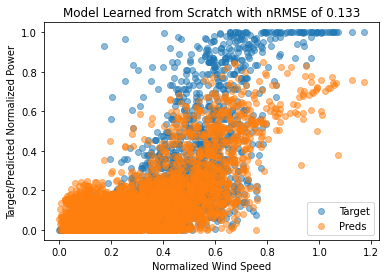

In [42]:
e = ((to_target_test.items.PowerGeneration.values.ravel()-preds.ravel())**2).mean()**0.5
plt.scatter(to_target_test.items.WindSpeed60m, to_target_test.items.PowerGeneration, label="Target",alpha=0.5)
plt.scatter(to_target_test.items.WindSpeed60m, preds, label="Preds",alpha=0.5)
plt.xlabel("Normalized Wind Speed")
plt.ylabel("Target/Predicted Normalized Power")
plt.title(f"Model Learned from Scratch with nRMSE of {e:.03f}")
plt.legend()
plt.show()